# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

# TODO could be good to also compare to ERA-Land (or select land only cell of ERA) to give indication if changes is mainly due to faster warming over land in general or actually over people specifically. Suspect that since places like canada are warming very fast but have low population, mean warming over land might be even faster than mean warming over people.

### Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

**NOTE: The aim of this final indicator is to have an axis in Kelvin, and this is probably the most important one. The reason for this is that it makes it easy to have plots of the raw temperature change and the exposure change side by side and demonstrate with comparable axes that there is an important difference between the change in temperature and the change in temperature experienced by people**


### Updates/Clarifications to Method

Aim is to measure 'temperature change experienced by people'. End goal is a value in Kelvin which is the equivalent of the global mean temperature change but weighted by population

We operate on gridded data.

First, just multiply the temperature change by the number of people at each point (x) for a given time (t):

$$
E(x,t) = \Delta T(x,t)P(x)
$$


We want to limit to the temperature change in the summer months for a given year, so first define all operations for a chosen year Y. The flobal $\Delta T(x,t)$ array is calculated by taking the mean temperature change for June, July, August for the northern hemisphere (latitude >= 0) and joining it with the array ofthe mean temperature change for December, January, February for the southern hemisphere (latitude < 0).

This gives a value in Kelvin x Npeople, which isn't hugely intuitive. When we take the global average with therefore divide by the total population for that year, $\sum P(x)$:

$$
\bar{E} = \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)}
$$

This can be repeated for each year to get a time series. However, we'd also like to map the value for each year in a similarly intuitive way. We can do this using the mean population per grid point:

$$
\bar{P} = \sum P(x) / N
$$

And calculating the exposure at each point as the population divided by the mean population:

$$
E(x,t) = \Delta T(x,t)P(x) / \bar{P}
$$

The average of this value over the grid (with number of points N) is equal to the $\bar{E}$:


$$
Mean = \frac{\sum \Delta T(x,t)P(x,t) / \bar{P} }{N} \\
= \frac{\sum \Delta T(x,t)P(x,t) / (\sum P(x) / N) }{N} \\
= \frac{ \tfrac{N}{\sum P(x)} \sum \Delta T(x,t)P(x,t) }{N} \\
= \frac{ N   \sum \Delta T(x,t)P(x,t) }{N \sum P(x)} \\
= \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)} = \bar{E} 
$$


#### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook

from config import (DATA_SRC, WEATHER_SRC, POP_DATA_SRC)

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'

In [4]:
MAX_YEAR = 2019

In [5]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

ERA_MONTHLY_FOLDER = WEATHER_SRC / 'era5' / 'monthly_means_0.5'
CLIMATOLOGY_FILE_MONTHLY = WEATHER_SRC / 'era5' / 'era_climatology_monthly_0.5.nc'
POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2020'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [6]:
# TODO where to put resuts now...
RESULTS_FOLDER = Path('./results/summer temperature change')
# RESULTS_FOLDER.mkdir(exist_ok=True, parents=True)
assert RESULTS_FOLDER.is_dir()

In [7]:
MAP_PROJECTION = ccrs.EckertIII()

# Load weather

In [8]:
temperature_monthly = xr.open_mfdataset(sorted(ERA_MONTHLY_FOLDER.glob('*.grib')), engine='cfgrib', combine='nested', concat_dim='time').t2m

In [9]:
climatology = xr.open_dataset(CLIMATOLOGY_FILE_MONTHLY).t2m

## Get ∆T for each month of each year relative to the ERA climatology monthly means file


In [10]:
def sub_months(era_t_yr):
    #Swap in the time axis so the datasets auto-align
    tmp = climatology.copy().rename({'month':'time'})
    tmp['time'] = era_t_yr.time
    return era_t_yr - tmp
    
delta_t = temperature_monthly.groupby('time.year').apply(sub_months)

In [11]:
import ipywidgets

def _plt_month(month=1, year=2000):
    (delta_t.sel(time=date(year, month, 1))).plot.imshow(vmin=-5, vmax=5, cmap='RdBu_r')

ipywidgets.interact(_plt_month, 
         month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
         year=ipywidgets.IntSlider(min=1980,max=MAX_YEAR,step=1,value=2000)
        );


interactive(children=(IntSlider(value=1, description='month', max=12, min=1), IntSlider(value=2000, descriptio…

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


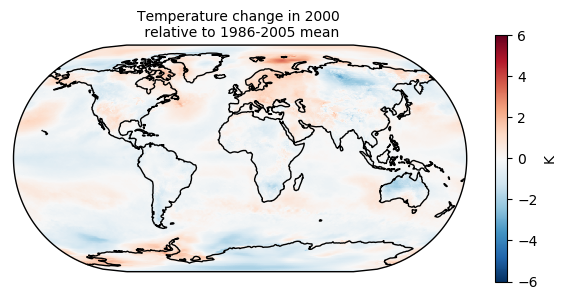

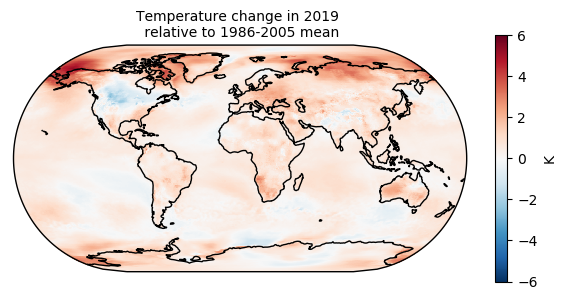

In [14]:
# Climate change in 2000
f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

delta_t.sel(time='2000').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title('Temperature change in 2000 \n relative to 1986-2005 mean')
plt.tight_layout()

f.show()

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

delta_t.sel(time=f'{MAX_YEAR}').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title(f'Temperature change in {MAX_YEAR} \n relative to 1986-2005 mean')
plt.tight_layout()

f.show()

## Get the mean delta for each summer

In [12]:
def collect_summer_delta(delta_t):
    """Split the word data into north and south, 
    keep only the summer months for each, then re-join them
    """
    # Wrap in a function to clear temporary vars from memory
    
    lat_north = delta_t.latitude[delta_t.latitude >= 0]    
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja, latitude=lat_north).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf,latitude=lat_south).groupby('time.year').mean(dim='time')
    
    return xr.concat([nh, sh], dim='latitude')

summer_anom = collect_summer_delta(delta_t)

In [13]:
# Clean up the data a bit
summer_anom = summer_anom.drop(['surface','step', 'number'])

In [17]:
def _plt_delta(year=2000):
    summer_anom.sel(year=year).plot(vmin=-5, vmax=5, cmap='RdBu_r')

ipywidgets.interact(_plt_delta, 
         month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
         year=ipywidgets.IntSlider(min=1980,max=MAX_YEAR,step=1,value=2000)
        );


interactive(children=(IntSlider(value=2000, description='year', max=2019, min=1980), Output()), _dom_classes=(…

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


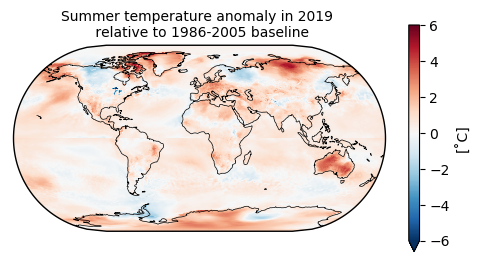

In [25]:
f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))


summer_anom.sel(year=MAX_YEAR).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='[˚C]'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines(linewidth=0.5)
ax.set_title(f'Summer temperature anomaly in {MAX_YEAR} \n relative to 1986-2005 baseline')
# plt.tight_layout()
f.savefig(RESULTS_FOLDER / f'summer_temperature_map_{MAX_YEAR}.png', dpi=300)
f.savefig(RESULTS_FOLDER / f'summer_temperature_map_{MAX_YEAR}.pdf', dpi=300)

f.show()

### Save the summer anomaly for use in the country calculation

In [ ]:
# summer_anom.name = 'summer_global'
summer_anom.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'summer_temperature_anomaly.nc')

In [ ]:
summer_anom = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'summer_temperature_anomaly.nc')

### Weight the gridded mean anomaly by the latitude and calculate the global mean

- It's important to weight the grid before calculating the mean to account for the change in area of grid units from the equator to the poles

In [14]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom * cos_lat).mean(dim=['latitude', 'longitude']).compute()

# Project summer anomaly to total population

In [15]:
population = xr.open_dataarray(POPULATION_FILE)

In [16]:
POPULATION_FILE_EXTENDED = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
population_extended =  xr.open_dataarray(POPULATION_FILE_EXTENDED)

## Calculate the exposure

In [21]:
summer_exposures_ts = (summer_anom * population / population.sum(dim=['latitude', 'longitude'], skipna=True)).sum(dim=['latitude', 'longitude'], skipna=True)

In [22]:
summer_exposures_ts = summer_exposures_ts.compute()

## Save/load the exposure time series

In [ ]:
summer_exposures_ts.name = 'summer_exposure'
summer_exposures_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx')


In [ ]:
summer_exposures_ts = pd.read_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx', index_col='year')
summer_exposures_ts = summer_exposures_ts.to_xarray().summer_exposure


## Plot the time series
# TODO maybe use the merged population data to go back to 1980

In [ ]:
summer_exposures_ts.plot(color='C0',label='Population weighted')

# Don't have population data before 2000 in this analysis (could use the merged one)
summer_anom_ts.sel(year=slice(2000,None)).plot(color='C1',label='Global mean')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')

summer_anom_params = stats.linregress(summer_anom_ts.sel(year=slice(2000,None)).year.values, summer_anom_ts.sel(year=slice(2000,None)).values)
summer_anom_reg = (summer_anom_params.slope * summer_anom_ts.sel(year=slice(2000,None)).year) + summer_anom_params.intercept

summer_exposures_params = stats.linregress(summer_exposures_ts.year.values, summer_exposures_ts.values)
summer_exposures_reg = (summer_exposures_params.slope * summer_exposures_ts.year) + summer_exposures_params.intercept

summer_exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')
summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('[˚C]')
plt.title('Mean summer temperature anomaly relative \n to 1986-2005 baseline')
plt.legend();
plt.savefig(RESULTS_FOLDER / f'summer_warming_2000-{MAX_YEAR}.png')
plt.savefig(RESULTS_FOLDER / f'summer_warming_2000-{MAX_YEAR}.pdf')


In [ ]:
summer_anom_params

In [ ]:
summer_exposures_params

In [ ]:
# Save to excel
output = summer_anom_ts.to_dataframe(name='Global mean change K').join(summer_exposures_ts.to_dataframe(name='Exposure weighted change K'))

output.to_excel(RESULTS_FOLDER / 'temperature_change.xlsx', sheet_name='temperature_change')

# Plot the summer trends using the extended population file

Gives a longer time series to better understand the trends

In [17]:
summer_exposures_extended_ts = ((summer_anom * population_extended / population_extended.sum(dim=['latitude', 'longitude'], skipna=True))
                                .sum(dim=['latitude', 'longitude'], skipna=True))

In [22]:

output = summer_anom_ts.to_dataframe(name='Global mean change K').join(summer_exposures_extended_ts.to_dataframe(name='Exposure weighted change K'))

output.to_excel(RESULTS_FOLDER / 'summer_temperature_anomaly global.xlsx', sheet_name='temperature_change')

In [24]:
output.to_csv(RESULTS_FOLDER / 'summer_temperature_anomaly global.csv')

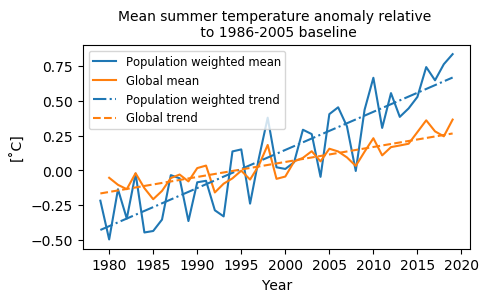

In [24]:
summer_exposures_extended_ts.plot(color='C0',label='Population weighted mean')
summer_anom_ts.sel(year=slice(1980,None)).plot(color='C1',label='Global mean')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')

summer_anom_params = stats.linregress(summer_anom_ts.year.values, summer_anom_ts.values)
summer_anom_reg = (summer_anom_params.slope * summer_anom_ts.year) + summer_anom_params.intercept

summer_exposures_params = stats.linregress(summer_exposures_extended_ts.year.values, summer_exposures_extended_ts.values)
summer_exposures_reg = (summer_exposures_params.slope * summer_exposures_extended_ts.year) + summer_exposures_params.intercept

summer_exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')
summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xlabel('Year')
plt.ylabel('[˚C]')
plt.title('Mean summer temperature anomaly relative \n to 1986-2005 baseline')
plt.legend();
plt.savefig(RESULTS_FOLDER / f'summer_warming_1980-{MAX_YEAR}.png')
plt.savefig(RESULTS_FOLDER / f'summer_warming_1980-{MAX_YEAR}.pdf')


In [46]:
summer_anom_params

LinregressResult(slope=0.010759525762908256, intercept=-21.457902839405026, rvalue=0.8803868539016598, pvalue=3.314636333286632e-14, stderr=0.0009281118916043859)

In [45]:
summer_exposures_params

LinregressResult(slope=0.027352869804244395, intercept=-54.55826490947283, rvalue=0.8857333533964267, pvalue=1.428077869871593e-14, stderr=0.0022954481027063194)